In [1]:
import glob
import os
import cv2
import numpy as np
import segmentation_models_pytorch as smp
import torch
import albumentations as A
import json

from dataloaders import TacoLoaders
from segmentation_models_pytorch import utils
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from utils import *
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from utils import visualize

In [2]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'
DEVICE = 'cuda'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(eps=1., activation = None),
]

In [3]:
class My_network():
    
    
    def __init__(self, loss, metrics):
        self.model = smp.Unet(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            classes=28, 
            activation=ACTIVATION,
        )
        
        self.optimizer = torch.optim.Adam([ 
            dict(params=self.model.parameters(), lr=0.0001),
        ])
        
        self.train_epoch = smp.utils.train.TrainEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            optimizer= self.optimizer,
            device=DEVICE,
            verbose=False,
        )

        self.valid_epoch = smp.utils.train.ValidEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            device=DEVICE,
            verbose=False,
        )
        
        
    def run_training(self, loaders, n_epochs=40, save_name='./best_model.pth'):
        max_score = 0
        for i in range(0, n_epochs):

            train_logs = self.train_epoch.run(loaders.train_loader)
            valid_logs = self.valid_epoch.run(loaders.valid_loader)
            
            if i%1==0: 
                print(f'==Epoch {i}==')
                print('Train/Val IoU:')
                print(round(train_logs['iou_score'] , 4))
                print(round(valid_logs['iou_score'] , 4))

            #if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(self.model, save_name)
    
    def eval(self, dataloader, model_path='./best_model.pth'):
        best_model = torch.load(model_path)
        test_epoch = smp.utils.train.ValidEpoch(
                         model=best_model,
                         loss=loss,
                         metrics=metrics,
                         device=DEVICE,
                         verbose=True
                      )

        logs = test_epoch.run(dataloader)
        return best_model

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
1200 150 150
Example image and mask:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


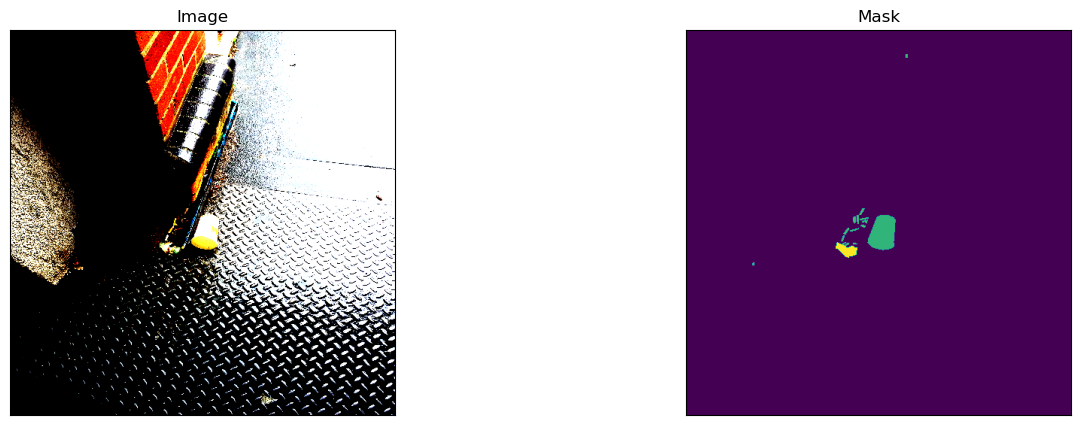

In [4]:
network = My_network(loss, metrics)
taco_loaders = TacoLoaders(augmentation=None, preprocessing_fn=preprocessing_fn)
print("Example image and mask:")
taco_loaders.show_example()

In [ ]:
print("Training model:")
network.run_training(taco_loaders, n_epochs=10)

Training model:
==Epoch 0==
Train/Val IoU:
0.0007
0.0006
==Epoch 1==
Train/Val IoU:
0.0007
0.0005


In [ ]:
print("Eval model:")
best_model = network.eval(taco_loaders.test_loader)
compare_predictions(taco_loaders, best_model)